# Setting up the problem

## Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import curve_fit
from scipy.stats import linregress
from math import pi, exp
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import warnings
import logging
import scienceplots
import os
import matplotlib

# set logging
logging.basicConfig(filename="droplet_transport.log", encoding='utf-8', level=logging.DEBUG)

# set matplotlib font
font = {'family': 'sans-serif', 'size':18}
matplotlib.rc('font', **font)

## Set initial conditions and declare constats

In [2]:
# CONSTANTS
T_infty = 23.0 + 273.15 # K
z0 = 1.7 # m
g = 9.81 # m/s^2
rho_g = 1.2041 # kg/m^3
RH = 0.7
p_sat_flat = 610.94*exp((17.625*T_infty)/(T_infty + 243.04)) # Pa -> August-Roche-Magnus approximation
R = 8.314462 # J / K*mol
MW_water = 0.018 #kg/mol
surface_tension = 0.0725 # N/m
water_density = 1e3 #kg/m^3
atmospheric_pressure = 101.325e3 # Pa
L = 2264.705 # J/kg
C_pd = 4.1813e3 # J/(kg K)
thermal_coeff_water = 0.6089 # W/(m K) 
dynamic_viscosity_water = 0.89e-3 # Pa s
mass_diffusivity_water = 2.2952e-9 # m^2/s
kB = 1.38066e-23 # botlzmann's constant
vm = 2.99e-29 # molecular volume of water (mol/m^3)
pr = C_pd*dynamic_viscosity_water/thermal_coeff_water # prandtl number

## Initialize some helper functions

In [3]:
def Re(v, D):
    # Assume T ~= 20 deg C, P~1atm (Table 2.3, Hinds)
    nu = 1.81e-5
    rho = 1.20 #kg/m^3
    re = rho*v*D/nu

    if re < 0:
        return 0

    return re

def p_sat_flat_T(T):
    return 610.94*exp((17.625*T)/(T + 243.04))
    
def drag_coefficient(v, D):
    # v in m/s
    # D in m    
    re = Re(v, D)

    if re > 1000:
        warnings.warn(f"Re = {re}, which is high. Drag coefficient may be incorrect")

    eps = np.finfo(float).eps
    if re <= eps:
        warnings.warn(f"Re = {re}, which is close to machine precision. Using drag coefficient = 0")
        return 0

    # Hinds Eq. 3.5
    return (24/re)*(1 + 0.15*(re**0.687))

def surface_area(D):
    return (pi)*(D**2)

def volume(D):
    return (pi/6)*(D**3)

def mass(D, D_df, return_water_mass=False):
    # returns mass in kg
    # D, D_df in m

    nucleus_density = 1.35e3 # kg/m^3
    water_density = 1e3 # kg/m^3

    if D <= D_df:
        return nucleus_density*volume(D)
    else:
        total_vol = volume(D)
        nucleus_vol = volume(D_df)
        water_vol = total_vol - nucleus_vol

        nucleus_mass = nucleus_vol*nucleus_density
        water_mass = water_vol*water_density
        total_mass = nucleus_mass + water_mass

        if not return_water_mass:
            return total_mass
        else:
            return water_mass

def moles_solute(m, water_mass):
    # mass and water mass as parameters
    # get the mass of the salt
    nacl_mass = m - water_mass
    
    # return the moles of solute
    return nacl_mass/(0.058443) # MW NaCl

def vapor_pressure_droplet(D, T, D_df):
    # get the moles of solution by the masses
    water_mass = mass(D, D_df, return_water_mass=True)
    m = mass(D, D_df)
    n = moles_solute(m, water_mass)

    # calculate the kelvin, raoult effects and the temperature
    kelvin_effect = (2*surface_tension)/(R*T*(D/2)*55.5e3) # 55.5 mol/L of water
    raoult_effect = (6*n*MW_water)/(pi*water_density*(D**3))
    p_sat_flat1 = p_sat_flat_T(T)

    # give back the vapor pressure of the droplet
    return (p_sat_flat1)*exp(kelvin_effect-raoult_effect)

def thermal_transport_coeff(re, D):
    # https://www.wikiwand.com/en/Nusselt_number#Sphere_in_convective_flow
    nu = 2 + 0.4*(re**0.5)*(pr**(1/3))

    return (nu*thermal_coeff_water/D)

def mass_transport_coeff(re, D, T):
    # calculate the diffusivity (D_t) at temperature T
    # https://www.wikiwand.com/en/Mass_diffusivity#Liquids
    # dynamic viscosity term drops out because we assume the air is not 
    # substantially heating up/cooling

    D_t = (0.260e-4)*((25+273.15)/T)

    # calculate the schmidt and sherwood numbers
    # https://www.wikiwand.com/en/Schmidt_number
    # https://www.wikiwand.com/en/Sherwood_number
    sc = dynamic_viscosity_water/(water_density*mass_diffusivity_water)
    sh = 2 + 0.552*(re**0.5)*(sc**(1/3))

    return (sh*mass_diffusivity_water)/D

def norm(vx, vz):
    return (vx**2 + vz**2)**0.5

def knudsen(d_p):
    mean_free_path = 0.066e-6 # Hinds Appendix A.1
    return 2*mean_free_path/d_p

In [4]:
def final_diameter(d0, salt_conc=0.009):
    # calculate the mass of salt
    total_volume = volume(d0)
    salt_volume = salt_conc*total_volume # 0.9% NaCl
    
    return 2*(3*salt_volume/(4*pi))**(1/3)

## Define the dynamic equations

The system of equations to be solved are the following:

$$\dot{m}_d = \frac{\rho_d \pi}{6} \frac{d}{dt} \left(D_d^3 \right) = -A_d h_m (p_{v,s} - p_{v, \infty})$$

$$m_d C_{P_d} \frac{d T_d}{dt} = A_d h (T_{\infty} - T_d) + L \dot{m_d}$$

$$m_d \frac{d^2 z}{d t^2} = \frac{1}{2} \rho_s v_z^2 A_d C_D - m_d g$$

$$\frac{dz}{dt} = v_z$$

$$m_d \frac{d^2 x}{d t^2} = \frac{1}{2} \rho_s v_x^2 A_d C_D$$

$$\frac{dx}{dt} = v_x$$

We want to solve for the dynamic variables $m$, $x$, and $z$

In [8]:
def evolve_system(t, y, final_dia, empirical_vx, airflow):
    # set up the state vector y as (D, x, z, v_x, v_z, T_d)
    # returns the time derivative of y
    # airflow in m/s

    # unpack y
    [D, x, z, v_x, v_z, T_d] = y
    
    # geometrical parameters
    m = mass(D, final_dia)
    sa = surface_area(D)
    V = volume(D)
    rho_d = m/V
    exposed_sa = sa/2 # for drag

    # thermodynamic parameters
    p_d = vapor_pressure_droplet(D, T_d, final_dia)

    # dynamic parameters
    v = norm(v_x, v_z) if not empirical_vx else norm(0.292/((x + 0.333)**2), v_z)
    re = Re(v, D)
    cd = drag_coefficient(v, D)

    # transport parameters
    h_m = mass_transport_coeff(re, D, T_d)
    h = thermal_transport_coeff(re, D)     

    # update the derivatives
    # check that the particle is appropriately sized:
    if D <= final_dia:
        dDdt = 0
    else:
        # dDdt = ((-2*sa*h_m)/((D**2)*rho_d*pi))*(p_d - RH*p_sat_flat)
        # calculate knudsen number and the factor
        kn = knudsen(D)
        fkn = (1+kn)/(1+1.71*kn+1.333*(kn**2))

        # calculate the derivative of the diameter
        dDdt = ((4*mass_diffusivity_water*vm)/(kB*T_infty*D))*(RH*p_sat_flat - p_d)*fkn
    dmdt = (rho_d * pi/6) * 3*(D ** 2)*dDdt
    dxdt = v_x + airflow
    dzdt = v_z
    dvxdt = -(0.5*rho_g*(v_x**2)*exposed_sa*cd)/m
    dvzdt = (0.5*rho_g*(v_z**2)*exposed_sa*cd - m*g)/m
    dTddt = (sa*h*(T_infty - T_d)+L*(dmdt))/(m*thermal_coeff_water)

    # logging statements if the reynold's number is huge
    if re > 1e6:
        logging.warn("VERY HIGH REYNOLDS NUMBER Re = {}".format(re))
        logging.debug(f"====================== SYSTEM PARAMETERS (t = {t:.2f}) ======================")
        logging.debug("GEOMETRY AND PHYSICAL:")
        logging.debug(f"diameter = {D}\nmass = {m}\nvolume = {V}\n (x, z) = ({x:.4f}, {z:.4f})\ntemp = {T_d}")
        logging.debug("DYNAMIC:")
        logging.debug(f"(vx, vz) = ({v_x}, {v_z})\nRe = {re}\ndrag coefficient = {cd}\nvapor pressure = {p_d}")
        logging.debug("TRANSPORT:")
        logging.debug(f"mass transport coefficient = {h_m}\nthermal transport coefficient = {h}")
        logging.debug("DERIVATIVES:")
        logging.debug(f"(dDdt, dxdt, dzdt, dvxdt, dvzdt, dTddt) = \n({dDdt},\n{dxdt},\n{dzdt},\n{dvxdt},\n{dvzdt},\n{dTddt})")
        logging.debug("===============================================================")

    

    # empirical x-vel condition from Dhawan and Biswas (2021)
    if empirical_vx:
        dxdt = airflow + 0.292/((x + 0.333)**2)
        dvxdt = 0

    # pack up all the derivatives and return
    dydt = [dDdt, dxdt, dzdt, dvxdt, dvzdt, dTddt]
    return dydt

## Settling Time of particle in Stoke's Flow

Here we use Stoke's Law to get a good time scale to solve the system of ODEs:

$$v_t = \frac{g d_p^2 \rho_p K_c}{18 \mu}$$
$$K_c = 1 + \mathrm{Kn}\left[1.257 + 0.400*\mathrm{exp} \left( \frac{-1.10}{\mathrm{Kn}} \right)\right]$$
$$\mathrm{Kn} = \frac{2 \lambda}{d_p}$$

In [6]:
def stokes_settling_time(d_p, rho_particle, z0):
    # z0, d_p in m
    # rho_particle in kg/m^3

    mean_free_path = 0.066e-6 # Hinds Appendix A.1
    Kn = 2*mean_free_path/d_p

    K_c = 1 + Kn*(1.257 + 0.400*exp(-1.10/Kn))

    vt = (g*(d_p**2)*rho_particle*K_c)/(18*(1.81e-5))

    return z0/vt # returns in seconds

## Solve

In [7]:
def solve_system(d0, salt_conc=0.009, N=int(1e6), tscale=2.5, debug=False, airflow = 0.0039, 
                 vx0 = 2.0, vz0 = 0, z0 = 1.7, T0 = 37.6 + 273.15, empirical_vx = False):
    # d0 - initial diamter
    # N - number of time steps [INTEGER]
    # tscale - how many factors of the settling time to solve the system
    # airflow - velocity of the surrounding air in the x-direction (m/s)
    # vx0 - initial speed of particles in x-dir (m/s)
    # vz0 - initial speed of particles in z-dir (m/s)
    # z0 - initial height (m)
    # T0 - initial temperature (K)

    # physical constants
    df = final_diameter(d0, salt_conc=salt_conc)
    mass0 = mass(d0, df)
    vol0 = volume(d0)

    # time constants
    tf = stokes_settling_time(df, mass0/vol0, z0)
    sample_ts = np.linspace(0, tf*tscale, N)

    if debug:
        print(f"estimated stokes settling time: {tf:,.2f} s [N = {N:.1e}] [dt = {tf*tscale/N:.2e} s]")
        print(f"final particle diameter: {df*1e6:.1f} μm")
        print(f"initial diameter stokes settling time: {stokes_settling_time(d0, mass0/vol0, z0):.2f} s")

    # initial state vector
    y0 = [d0, 0, z0, vx0, vz0, T0] # [D, x, z, v_x, v_z, T_d]

    # solve and return
    solution_bunch = solve_ivp(evolve_system, 
                                (sample_ts[0], sample_ts[-1]), 
                                y0, 
                                args=(df, empirical_vx, airflow), 
                                method='Radau',
                                t_eval = sample_ts)

    return (solution_bunch.t, solution_bunch.y)

# solve the system
d0 = 100e-6
sample_ts, soln = solve_system(d0, debug=True, tscale=200, empirical_vx=True, z0=1.7)
final_dia = final_diameter(d0)
final_mass = 2.17e3*volume(final_dia)

# parse out solution for easier graphing
Ds = soln[0, :]
Ts = soln[5, :]
xs = soln[1, :]
zs = soln[2, :]

estimated stokes settling time: 129.05 s [N = 1.0e+06] [dt = 2.58e-02 s]
final particle diameter: 20.8 μm
initial diameter stokes settling time: 5.62 s


## Plot Trajectory

C:\Users\Jobim\AppData\Local\Temp\ipykernel_22452\2578154974.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


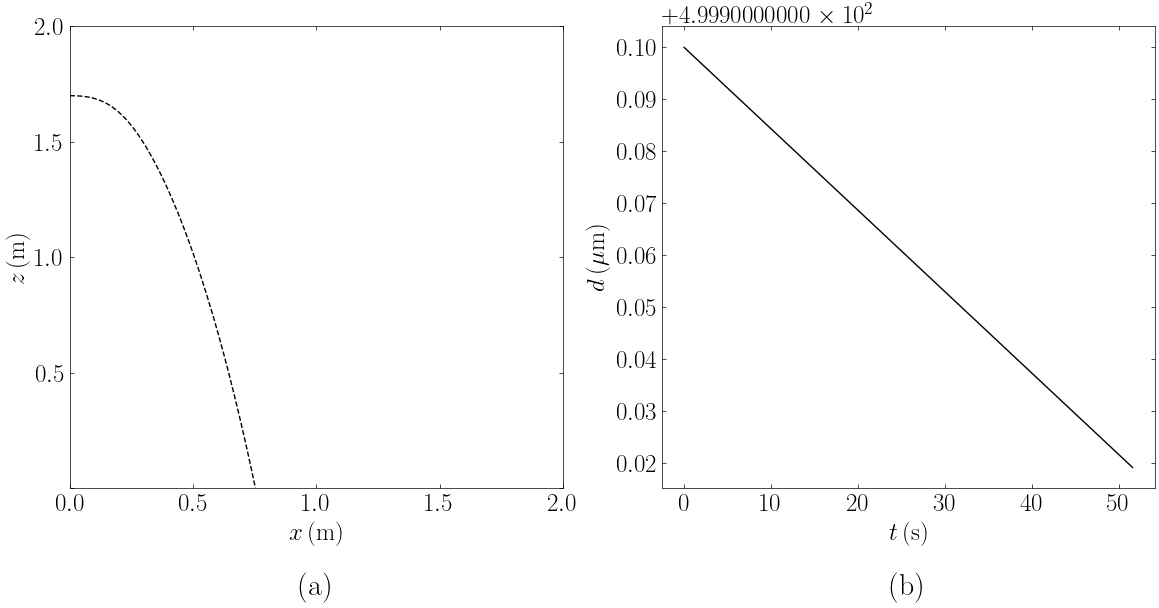

In [18]:
# set matplotlib rendering
%matplotlib inline
plt.rcParams.update({"text.usetex": True})

# set the save path
FIG_SAVEPATH = os.path.abspath(r"C:\Users\Jobim\Desktop\school 23-24\research\marr\code\figs")

# set the plotting style
plt.style.use(['science'])

fig, ax = plt.subplots(1,2)
fig.set_size_inches(14, 6)

ax[0].plot(xs, zs, "k--")
ax[0].set_xlim(0, 2)
ax[0].set_ylim(0, 2)
ax[0].set_xlabel("$x \, (\mathrm{m})$")
ax[0].set_ylabel("$z \, (\mathrm{m})$")
ax[0].set_title("(a)", y=-0.25)
ax[0].tick_params(axis='both', which='minor', bottom=False, top=False, left=False, right=False)
ax[0].set_yticks([0, 0.5, 1.0, 1.5, 2.0])

plot_n = int(2e-3*sample_ts.shape[0])
ax[1].set_xlabel("$t \, (\mathrm{s})$")
ax[1].set_ylabel("$d \, (\mu \mathrm{m})$")
ax[1].plot(sample_ts[:plot_n], 1e6*Ds[:plot_n], "k")
ax[1].set_title("(b)", y=-0.25)
ax[1].tick_params(axis='both', which='minor', bottom=False, top=False, left=False, right=False)


# remove the first y tick (zero)
yticks = ax[0].yaxis.get_major_ticks() 
yticks[0].label1.set_visible(False)

fig.show()
# fig.savefig(os.path.join(FIG_SAVEPATH, 'single_particle.svg'))

# Sensitivity Analysis on Initial Salt Concentration

To determine how sensitive the settling time is on the initial concentration

## Numerically Solve for Settling Time

Define a short function to find where the zero is and return the settling time

In [9]:
def find_zero(zs, ts):
    # zs - z values
    # ts - time corresponding to zs
    # returns index in zs and settling time

    if len(zs) != len(ts):
        raise Exception("z-values and times must have the same length")

    # initialize a previous z
    zprev = -99e50

    # iterate through the z-list to find where it goes from negative to positive
    # iterate backwards since the zero is more likely to be closer to the end
    for i in range(-1, -len(zs), -1):
        zcurrent = zs[i]

        # if it switches sign, then we are done
        if zcurrent >= 0 and zprev < 0:
            return (i, ts[i])
        
        zprev = zcurrent

In [10]:
index, t_settling = find_zero(zs, sample_ts)
print(f"particle settled in {t_settling:.2f} s\ntotal time solved {sample_ts[-1]:.2f} s")
print(f"settling distance: {xs[index]:.2f} m")

particle settled in 10.45 s
total time solved 25809.70 s
settling distance: 2.71 m


## Monte-Carlo Step:

1. Sample from a normal distribution of initial salt content
2. Solve the system
3. Calculate the settling time (numerical)
4. Plot a histogram of the salt concentration and the corresponding settling time distribution

In [213]:
def salt_monte_carlo(d0, N=int(1e3), stdv_salt=1e-4):
    # initialize salt concentration array and settling time array
    salt_concs = np.zeros((N), dtype=np.float32)
    settling_times = np.zeros((N), dtype=np.float32)

    # go through N monte-carlo simulations
    for i in tqdm(range(N)):
        # sample from a normal distribution
        current_salt_conc = np.random.normal(loc=0.009, scale=stdv_salt)

        # solve the system
        ts, soln = solve_system(d0, salt_conc=current_salt_conc, tscale=20, empirical_vx=True)

        # calculate the settling time
        zs = soln[2, :]
        _, current_settling_time = find_zero(zs, ts)

        # add the concentration and settling time to the array
        salt_concs[i] = current_salt_conc
        settling_times[i] = current_settling_time

    # return the concentrations and settling times
    return (salt_concs, settling_times)

## Compute and plot the results

In [214]:
salt_concs, settling_times = salt_monte_carlo(100e-6)

100%|██████████| 1000/1000 [05:54<00:00,  2.82it/s]


C:\Users\Jobim\AppData\Local\Temp\ipykernel_12300\593884346.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


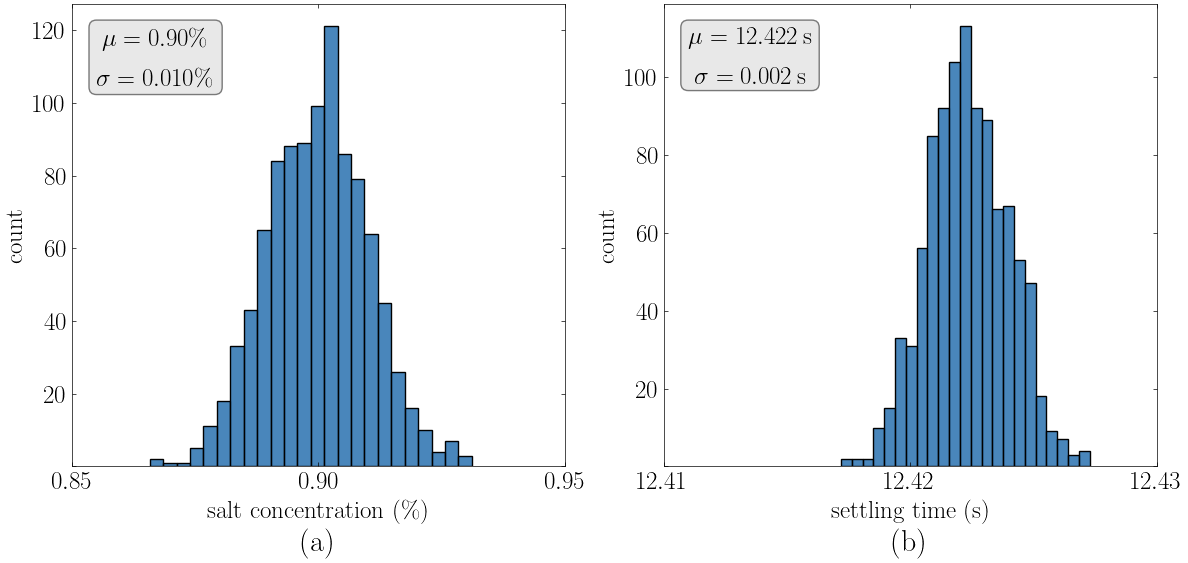

In [234]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(14, 6)
                  
# calculate statistics                  
mu_salt = np.mean(salt_concs)
sigma_salt = np.std(salt_concs)
mu_settling = np.mean(settling_times)
sigma_settling = np.std(settling_times)

# plot a
sns.histplot(data=100*salt_concs, ax=ax[0])
ax[0].set_xlabel(r"salt concentration (\%)")
ax[0].set_ylabel("count")
ax[0].set_title("(a)", y=-0.2)
ax[0].set_xlim(0.85, 0.95)
ax[0].tick_params(axis='both', which='minor', bottom=False, top=False, left=False, right=False)
ax[0].set_xticks([0.85, 0.90, 0.95])
yticks = ax[0].yaxis.get_major_ticks() 
yticks[0].label1.set_visible(False)
textstr = r"$$\mu = %.2f \%% $$$$\sigma = %.3f \%% $$" % (100*mu_salt, 100*sigma_salt)
props = dict(boxstyle='round', facecolor='lightgray', alpha=0.5)
ax[0].text(0.05, 0.95, textstr, transform=ax[0].transAxes, fontsize=18,
        verticalalignment='top', bbox=props)

# plot b
sns.histplot(data=settling_times, ax=ax[1])
ax[1].set_xlabel("settling time (s)")
ax[1].set_ylabel("count")
ax[1].set_title("(b)", y=-0.2)
ax[1].set_xlim(12.41, 12.43)
ax[1].set_xticks([12.41, 12.42, 12.43])
ax[1].tick_params(axis='both', which='minor', bottom=False, top=False, left=False, right=False)
yticks = ax[1].yaxis.get_major_ticks() 
yticks[0].label1.set_visible(False)
textstr = r"$$\mu = %.3f \, \mathrm{s}$$$$\sigma = %.3f \, \mathrm{s}$$" % (mu_settling, sigma_settling)
props = dict(boxstyle='round', facecolor='lightgray', alpha=0.5)
ax[1].text(0.05, 0.95, textstr, transform=ax[1].transAxes, fontsize=18,
        verticalalignment='top', bbox=props, horizontalalignment='left')

fig.show()

# Dynamic Observations:
Want to find the relationship between initial diameter and settling distance and initial diameter and final diameter.

In [16]:
# define the trials
N = int(1e2)
TRIALS = 1
d0s = np.zeros((N*TRIALS,))
for trial in range(TRIALS):
    d0s[trial*N:(trial+1)*N] = np.logspace(np.log10(10e-6), np.log10(500e-6), N)

# initialize the results
settling_distances = np.zeros((TRIALS*N, 1)) # settling distances
initial_diameters = np.zeros((TRIALS*N, 1)) # initial diameters
final_diameters = np.zeros((TRIALS*N, 1)) # final diameters
settling_times = np.zeros((TRIALS*N, 1)) # settling times


for array_index, d0 in tqdm(enumerate(d0s)):
    # solve the system for the initial diameter d0
    ts, soln = solve_system(d0, tscale=20, empirical_vx = True)

    # parse out the relevant results
    Ds = soln[0, :]
    xs = soln[1, :]
    zs = soln[2, :]

    # find the settling time and settling index
    settling_index, settling_time = find_zero(zs, ts)

    # add the new results to the array in the appropriate spot
    settling_distances[array_index] = xs[settling_index]
    initial_diameters[array_index] = d0
    final_diameters[array_index] = Ds[settling_index]
    settling_times[array_index] = settling_time

21it [00:10,  1.90it/s]C:\Users\Jobim\AppData\Local\Temp\ipykernel_22452\929392149.py:25: UserWarning: Re = 0, which is close to machine precision. Using drag coefficient = 0
  warnings.warn(f"Re = {re}, which is close to machine precision. Using drag coefficient = 0")
100it [01:00,  1.65it/s]


## Plot the Results

C:\Users\Jobim\AppData\Local\Temp\ipykernel_22452\450634675.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


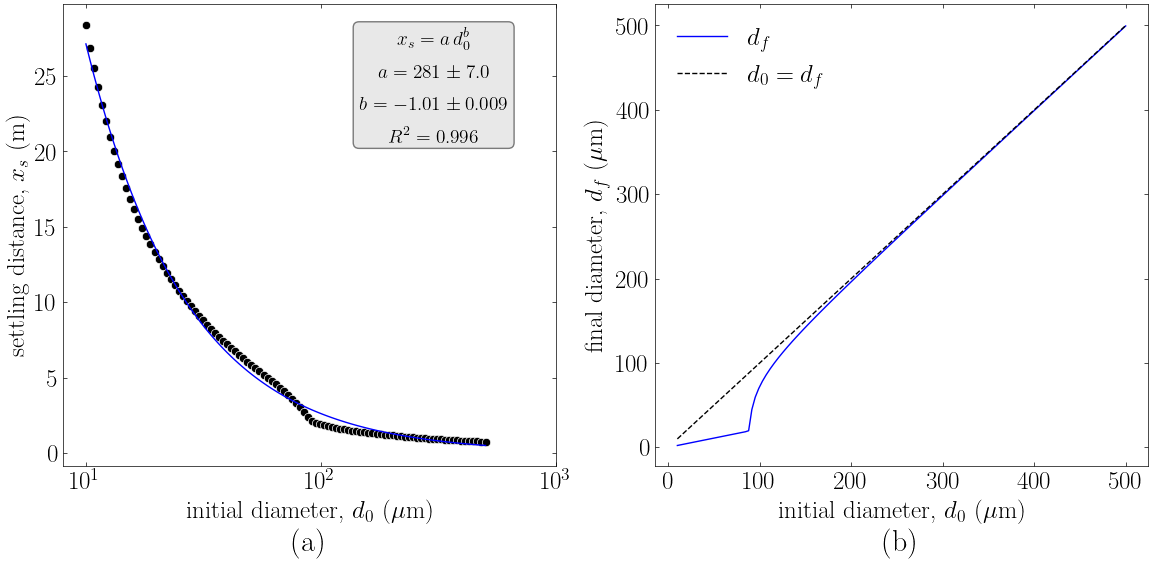

In [19]:
from sklearn.metrics import r2_score

# fit the exponential of best fit
model = lambda dia,a,b: a * np.power(dia, b*np.ones(dia.shape))
[a, b], pcov = curve_fit(model, 1e6*initial_diameters.T[0], settling_distances.T[0])
[perr_a, perr_b] = np.sqrt(np.diag(pcov))
r2 = r2_score(model(1e6*initial_diameters.T[0], a, b), settling_distances.T[0])


# fit linear model
lin_model = lambda x, a, b: a*x + b
[m, intercept], pcov = curve_fit(lin_model, 1e6*initial_diameters.T[0], 1e6*final_diameters.T[0])
[perr_m, perr_intercept] = np.sqrt(np.diag(pcov))
lin_r2 = r2_score(model(1e6*initial_diameters.T[0], a, b), settling_distances.T[0])


# plot the results
fig, ax = plt.subplots(1,2)
fig.set_size_inches(14, 6)

data1 = pd.DataFrame(np.reshape(np.concatenate((1e6*initial_diameters, settling_distances), axis=1), (N*TRIALS, 2)), columns=["initial_diameter", "settling_distance"])
data2 = pd.DataFrame(np.reshape(np.concatenate((1e6*initial_diameters, 1e6*final_diameters), axis=1), (N*TRIALS, 2)), columns=["initial_diameter", "final_diameter"])

# plotting the first figure
sns.scatterplot(data=data1, ax=ax[0], x="initial_diameter", y="settling_distance", color='black')
ax[0].plot(np.sort(1e6*initial_diameters.T[0]), model(np.sort(1e6*initial_diameters.T[0]), a, b), "b-")
ax[0].set_xscale('log')
ax[0].set_xlim(8, 1000)
ax[0].set_xlabel("initial diameter, $d_0$ ($\mu$m)")
ax[0].set_ylabel("settling distance, $x_s$ (m)")
textstr = r"$$x_s = a \, d_0^{b}$$$$a = %.0f \pm %.1f$$$$b = %.2f \pm %.3f$$$$R^2 = %.3f$$" % (a, perr_a, b, perr_b, r2)
textstr = textstr.replace("e", "\\times 10^{")
props = dict(boxstyle='round', facecolor='lightgray', alpha=0.5)
ax[0].text(0.6, 0.95, textstr, transform=ax[0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax[0].set_title("(a)", y=-0.2)
ax[0].tick_params(axis='both', which='minor', bottom=False, top=False, left=False, right=False)

# plotting the second figure
sns.lineplot(data=data2, ax=ax[1], x="initial_diameter", y="final_diameter", color='blue', label='$d_f$')
d0_equals_df = ax[1].plot(1e6*initial_diameters.T[0], 1e6*initial_diameters.T[0], 'k--', label='$d_0 = d_f$')
ax[1].set_xlabel("initial diameter, $d_0$ ($\mu$m)")
ax[1].set_ylabel("final diameter, $d_f$ ($\mu$m)")
ax[1].set_title("(b)", y=-0.2)
ax[1].tick_params(axis='both', which='minor', bottom=False, top=False, left=False, right=False)
ax[1].legend()

fig.show()

To do:
1. Cough distribution velocity profile in x direction [using this paper](https://pubs.acs.org/doi/full/10.1021/acs.est.1c00235)
2. Double check the above^
3. Add the figure that Nishit has 35, 50, 70, 100, 500 um particle diameter settling distances on the same plot
4. Start at y = 0 to y = -4 inches and see how far it travels ~38 inches for the smallest. For both speaking and coughing
5. For x-velocity, in addition add a small correction for the flow speed 0.0039 m/s to the velocity for non-stationary flow 

## Characterize the settling times
Add a plot showing the trajectories for various particle diameters. First, perform the calculations and get trajectories

In [261]:
# initial conditions
diameters = np.array([35, 50, 70, 100, 500])*1e-6 # um
z0 = 4 * 0.0254 # in -> m

settling_trajectories = {}

# iterate and solve through each diameter
for i, dia in enumerate(diameters):
    # solve the system with the initial diameter, dia
    sample_ts, soln = solve_system(dia, debug=False, tscale=20, empirical_vx=True, z0=z0, airflow=0.05)
    zs = soln[2, :] # parse out the vertical coordinates from the solution
    xs = soln[1, :]
    Ds = soln[0, :]

    # find the settling distance
    settling_index, t_settling = find_zero(zs, sample_ts)
    set_dist = xs[settling_index]
    set_dia = Ds[settling_index]

    # print the result
    print(f"particle d0 = {round(dia*1e6)} um df = {round(set_dia*1e6)} um settled in x = {set_dist*39.37008:.1f} in")

    # settling array with the x-trajectory in the first item in axis 1 and the z-trajectory in the second item in axis 1
    settling_array = np.stack((xs[:settling_index], zs[:settling_index]), axis=1)
    settling_trajectories[dia] = settling_array


particle d0 = 35 um df = 29 um settled in x = 41.9 in
particle d0 = 50 um df = 48 um settled in x = 33.7 in
particle d0 = 70 um df = 69 um settled in x = 28.4 in
particle d0 = 100 um df = 99 um settled in x = 24.2 in
particle d0 = 500 um df = 500 um settled in x = 17.1 in


Plot and format the results

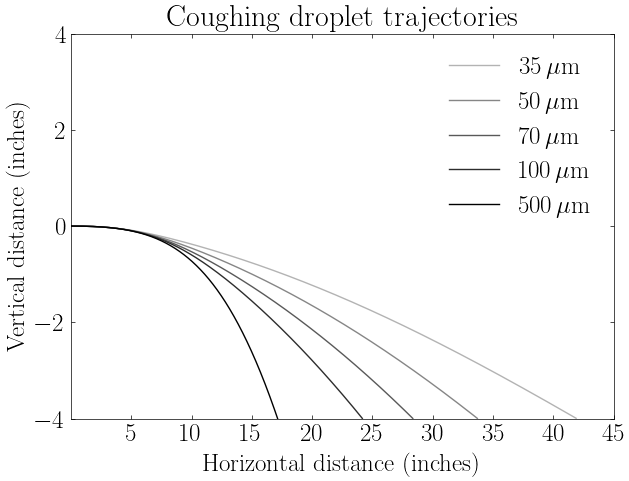

In [262]:
matplotlib.rc('figure', figsize=(7, 5))

plt.xlabel("Horizontal distance (inches)")
plt.ylabel("Vertical distance (inches)")
plt.title("Coughing droplet trajectories")

plt.tick_params(axis='both', which='minor', bottom=False, top=False, left=False, right=False)

# get the colors
n_diams = len(settling_trajectories)
colors = [(x, x, x) for x in np.linspace(0.0, 0.7, n_diams)][::-1]

for i, diameter in enumerate(settling_trajectories):
    
    plt.plot(39.37008*settling_trajectories[diameter][:,0], 
             39.37008*settling_trajectories[diameter][:,1]-4*np.ones_like(settling_trajectories[diameter][:,1]),
             label = str(round(1e6*diameter)) + r"$\, \mu \mathrm{m}$", color=colors[i]) 

plt.xlim(0, 45)
plt.xticks([x for x in range(0, 46, 5)][1:])
plt.ylim(-4, 4)
plt.legend()
plt.show()